In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

In [23]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/top40_cell_cycle.csv")

# Separate features and target
X = df.drop(columns=['phase', 'age'])  # drop non-feature columns
y = df['age']

In [40]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

# Fit Lasso regression with 10-fold CV to select best alpha
lasso_cv = LassoCV(alphas = (0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000), cv=10, random_state=949, max_iter = 1000)
lasso_cv.fit(X_train, y_train)

# Best alpha
print(f"Best alpha (lambda): {lasso_cv.alpha_:.5f}")
best_alpha = lasso_cv.alpha_

Best alpha (lambda): 0.01000


In [34]:
lasso_cv.mse_path_

array([[25.0073343 , 27.50152418, 29.44392954, 26.35542641, 26.21337194,
        25.59079608, 26.2698735 , 27.52727045, 26.82487086, 28.60287684],
       [25.0073343 , 27.50152418, 29.44392954, 26.35542641, 26.21337194,
        25.59079608, 26.2698735 , 27.52727045, 26.82487086, 28.60287684],
       [25.0073343 , 27.50152418, 29.44392954, 26.35542641, 26.21337194,
        25.59079608, 26.2698735 , 27.52727045, 26.82487086, 28.60287684],
       [ 7.23235086,  7.85567423,  8.93755699,  8.788651  ,  8.68421616,
         6.9332705 ,  8.00313407,  8.30933394,  8.31360143,  9.42193886],
       [ 4.29622197,  4.90773569,  5.03106181,  4.9795916 ,  5.70651854,
         4.11520478,  5.64403742,  5.34622112,  5.22238348,  5.52484243],
       [ 4.18454513,  4.52593289,  4.64228381,  4.84212424,  5.32994069,
         3.76159153,  5.19906424,  5.18185246,  4.74234608,  4.93167969],
       [ 4.22957468,  4.53443182,  4.6122938 ,  4.88199589,  5.35849726,
         3.77746041,  5.16360241,  5.23299653

In [32]:
# Predict on training and test sets
y_train_pred = lasso_cv.predict(X_train)
y_test_pred = lasso_cv.predict(X_test)

In [39]:
rmse_mean = np.sqrt(np.mean(lasso_cv.mse_path_, axis=1))
rmse_std = np.std(lasso_cv.mse_path_, axis=1) / (2 * rmse_mean)

alphas = lasso_cv.alphas_

sorted_indices = np.argsort(alphas)
alphas_sorted = alphas[sorted_indices]
rmse_mean_sorted = rmse_mean[sorted_indices]
rmse_std_sorted = rmse_std[sorted_indices]

# Find index of minimum RMSE
min_idx = np.argmin(rmse_mean_sorted)
one_se_threshold = rmse_mean_sorted[min_idx] + rmse_std_sorted[min_idx]

# Select largest alpha with RMSE within 1 SE of the minimum
one_se_alpha = alphas_sorted[rmse_mean_sorted <= one_se_threshold][-1]
best_alpha = alphas_sorted[min_idx]

print(f"Alpha with 1-SE Rule (using RMSE): {one_se_alpha:.5f}")
print(best_alpha)

Alpha with 1-SE Rule (using RMSE): 0.10000
0.01


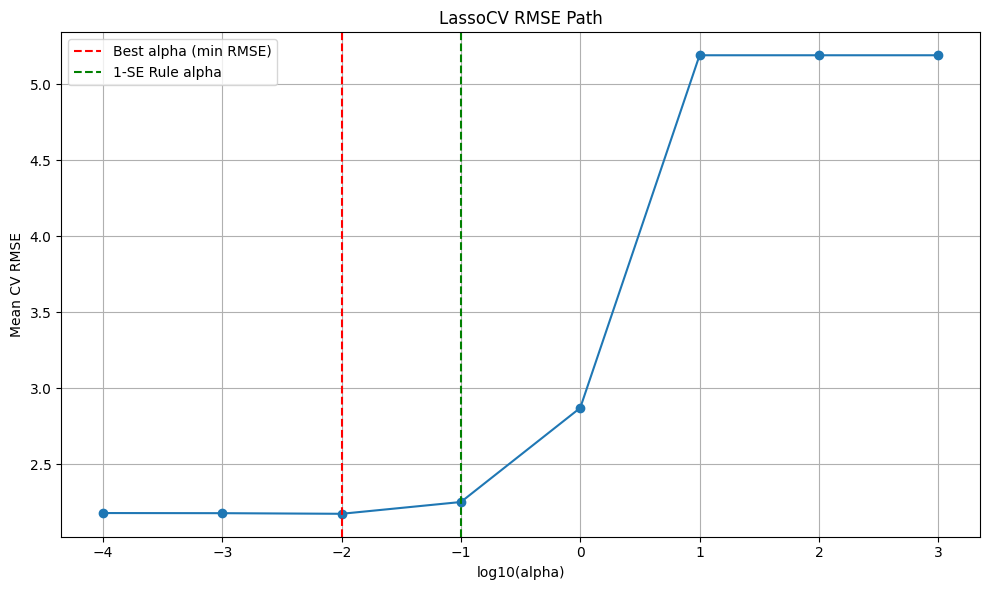

In [41]:
# Plot CV MSE path with 1-SE Rule
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alphas), rmse_mean, '-o')
plt.axvline(np.log10(best_alpha), color='red', linestyle='--', label='Best alpha (min RMSE)')
plt.axvline(np.log10(one_se_alpha), color='green', linestyle='--', label='1-SE Rule alpha')
plt.xlabel('log10(alpha)')
plt.ylabel('Mean CV RMSE')
plt.title('LassoCV RMSE Path')
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = "lasso_top40_path.png"
plt.savefig(plot_path, dpi=300)
plt.show()

Alpha with minimum BIC: 0.01000


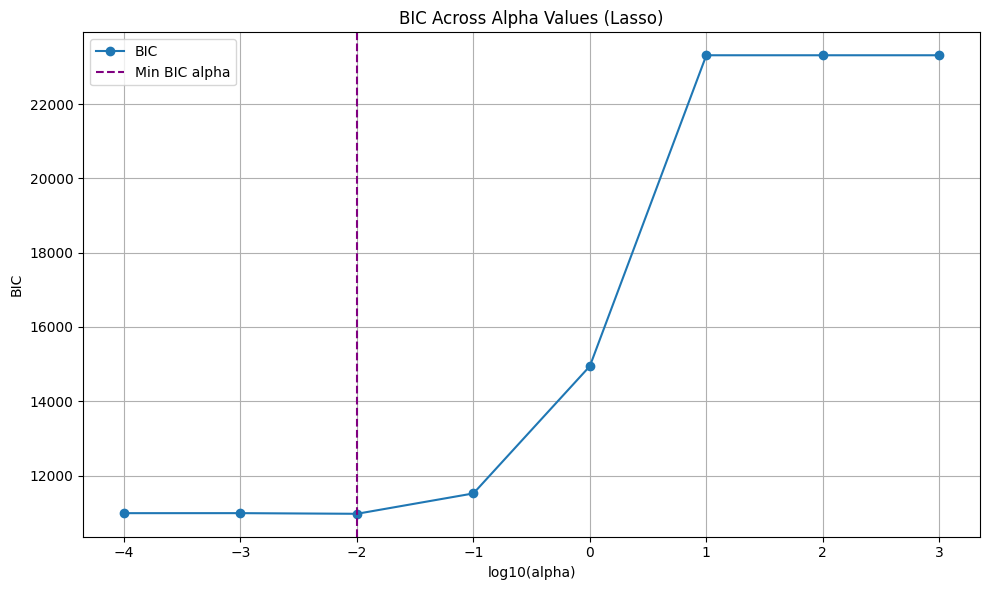

In [42]:
n = len(y_train)
bic_values = []

# Compute BIC for each alpha
for alpha in alphas:
    model = Lasso(alpha=alpha, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    rss = np.sum((y_train - y_pred) ** 2)
    k = np.sum(model.coef_ != 0)  # number of non-zero coefficients
    bic = n * np.log(rss / n) + k * np.log(n)
    bic_values.append(bic)

# Find alpha with minimum BIC
min_bic_idx = np.argmin(bic_values)
best_bic_alpha = alphas[min_bic_idx]
print(f"Alpha with minimum BIC: {best_bic_alpha:.5f}")

# Plot BIC
plt.figure(figsize=(10, 6))
plt.plot(np.log10(alphas), bic_values, 'o-', label='BIC')
plt.axvline(np.log10(best_bic_alpha), color='purple', linestyle='--', label='Min BIC alpha')
plt.xlabel('log10(alpha)')
plt.ylabel('BIC')
plt.title('BIC Across Alpha Values (Lasso)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plot_path = "lasso_top40_path_bic.png"
plt.savefig(plot_path, dpi=300)
plt.show()

In [ ]:
# Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)


# Calculate R^2
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")
print(f"R^2: {r2_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")
print(f"R^2: {r2_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: root_mean_squared_error(x['true_age'], x['pred_age'])
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)